In [1]:
%load_ext autoreload
%autoreload 2
from RTKToArrayConversion import *
from ExtendedConeBeamDCC import *
from TextFileSaving import * 
from ConeBeamDCCWithBackprojectionPlane import *

In [2]:
filesdir_ref = "/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/VJL/donneesBrutes/sans_comp/n20_n50/"
# reading projections
proj = itk.imread(filesdir_ref+"proj_diaphragm.mha")
# Reading the geometry of the scanner
xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
xmlreader.SetFilename(filesdir_ref+'geometry_diaphragm.xml')
# xmlreader.SetFilename(filesdir_ref+"geometry.xml")
xmlreader.GenerateOutputInformation()
geometry = xmlreader.GetOutputObject()
print('nproj = %d'%(len(geometry.GetGantryAngles())))
print(proj.GetLargestPossibleRegion().GetSize())

nproj = 26681
itkSize3 ([920, 32, 26681])


In [3]:
#Convert to array for faster computation
geometry_array = RTKtoNP(geometry)
proj_array = itk.GetArrayFromImage(proj)
proj_infos = GetProjectionInformations(proj)
source_pos_array = GetSourcePositions(geometry)
rotation_matrices_array = GetRotationMatrices(geometry)
fixed_matrices_array = GetFixedSystemMatrices(geometry)
print(proj_infos)

[array([1.02806101, 1.0947541 , 1.        ]), array([0., 0., 0.]), array([  920,    32, 26681]), array([[ 1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])]


In [4]:
# print(np.where(geometry_array[8,:]>0))

In [5]:
from joblib import Parallel, delayed
from tqdm import tqdm_notebook
import time

ref = 13340
N = 10
res = []
res_bp = []
idx_bp = []

for i in tqdm_notebook(range(-ref,ref)):
    res.append(ComputeDCCsForOnePair(ref, i + ref, geometry_array, source_pos_array, rotation_matrices_array, fixed_matrices_array, proj_array, proj_infos))

# for i in tqdm_notebook(range(-n_proj_rot//2,n_proj_rot//2)):
#     if np.cos(geometry_array[2, ref]-geometry_array[2, ref+i]) > 2*((250)/geometry_array[0,0])**2-1:
#         idx_bp.append(i+ref)
#         res_bp.append(ComputeDCCsBPForOnePair(ref, i + ref, geometry, proj))

# start = time.time()
# res = Parallel(n_jobs=4)(delayed(ComputeDCCsForOnePair)(ref, i + ref, geometry_array, source_pos_array, rotation_matrices_array, fixed_matrices_array, proj_array, proj_infos) for i in range(-n_proj_rot//2,n_proj_rot//2))

# print(time.time()-start)
# for i in tqdm_notebook(range(-500,500)):
#     res_bp.append(ComputeDCCsBPForOnePair(ref, i+ref, geometry, proj))

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


invalid value encountered in true_divide


<IPython.core.display.Javascript object>


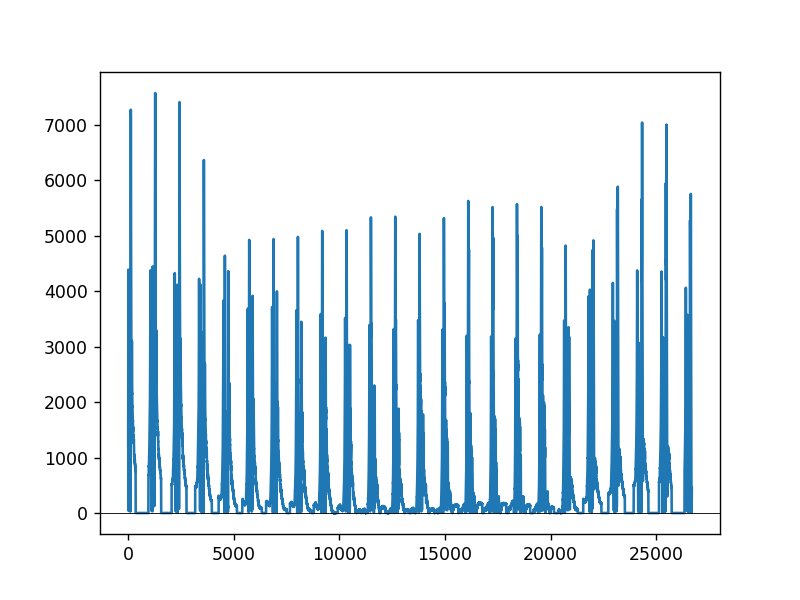

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook
# plot results
plt.figure()
plt.plot((np.arange(-ref,ref)+ref),[Difference(res[i][0], res[i][1]) for i in range(len(res))])
# plt.plot([NormalizedError(res[i][0], res[i][1], res[i][2]) for i in range(len(res))])
# plt.plot(np.arange(-500,500)+ref,[Difference(res_bp[i][0], res_bp[i][1]) for i in range(len(res_bp))])
plt.axhline(y=0, color='k', linewidth=0.5)
plt.show()
    

In [8]:
# savedir = "/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu/statistics/new_results/FOV2/"
# WriteMomentsFile(savedir+"thorax_b_360_920x1028_rect_W.csv",res, 4*N)